In [1]:
#import required libraries
import keras
import keras.backend as K
import numpy as np 
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#Load the fashion MNIST dataset from Keras and normalise the train and test set
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train /  255
x_test = x_test / 255
x_train = np.expand_dims(x_train, 3)
x_test = np.expand_dims(x_test, 3)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [3]:
#num_train_per_class = 100
#num_train_per_class = 200
num_train_per_class = 500
n_epochs = 10

In [4]:
#generate triplets of anchor, positive and negative images through random sampling in the dataset.
def gen_triplets(data, label, samples=100):
  x, y = None, None
  for i in range(10):
    pos_indices = np.argwhere(label == i)[:,0]
    neg_indices = np.argwhere(label != i)[:,0]
    anchor = np.random.choice(pos_indices.shape[0], samples, replace=False)
    anchor = pos_indices[anchor]
    pos = np.random.choice(pos_indices.shape[0], samples, replace=False)
    pos = pos_indices[pos]
    neg = np.random.choice(neg_indices.shape[0], samples, replace=False)
    neg = neg_indices[neg]
    sub_x_anc = data[anchor]    
    sub_x_pos = data[pos]
    sub_x_neg = data[neg]
             
    if(x is None):
      x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
      y = [label[anchor], label[pos], label[neg]]
    else:
      x[0] = np.vstack((x[0], (sub_x_anc)))
      x[1] = np.vstack((x[1], (sub_x_pos)))
      x[2] = np.vstack((x[2], (sub_x_neg)))

      y[0] = np.hstack((y[0].flatten(), label[anchor].flatten()))
      y[1] = np.hstack((y[1].flatten(), label[pos].flatten()))
      y[2] = np.hstack((y[2].flatten(), label[neg].flatten()))
    
  return x, y

In [5]:
train_x, train_y = gen_triplets(x_train, y_train)

In [6]:
#display the anchor, postitive and negative images respectively 
def visualize(data, n = 10):
  n = min(len(data[0]), n)
  random_choices = np.random.choice(len(data[0]),n, replace=False)
  fig, ax = plt.subplots(n, 3,figsize=(10,40))
  anc, pos, neg = data
  for i,c in enumerate(random_choices):
    ax[i, 0].imshow(np.squeeze(anc[c] ))
    ax[i, 1].imshow(np.squeeze(pos[c] ))
    ax[i, 2].imshow(np.squeeze(neg[c] ))
    

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].set_axis_off()

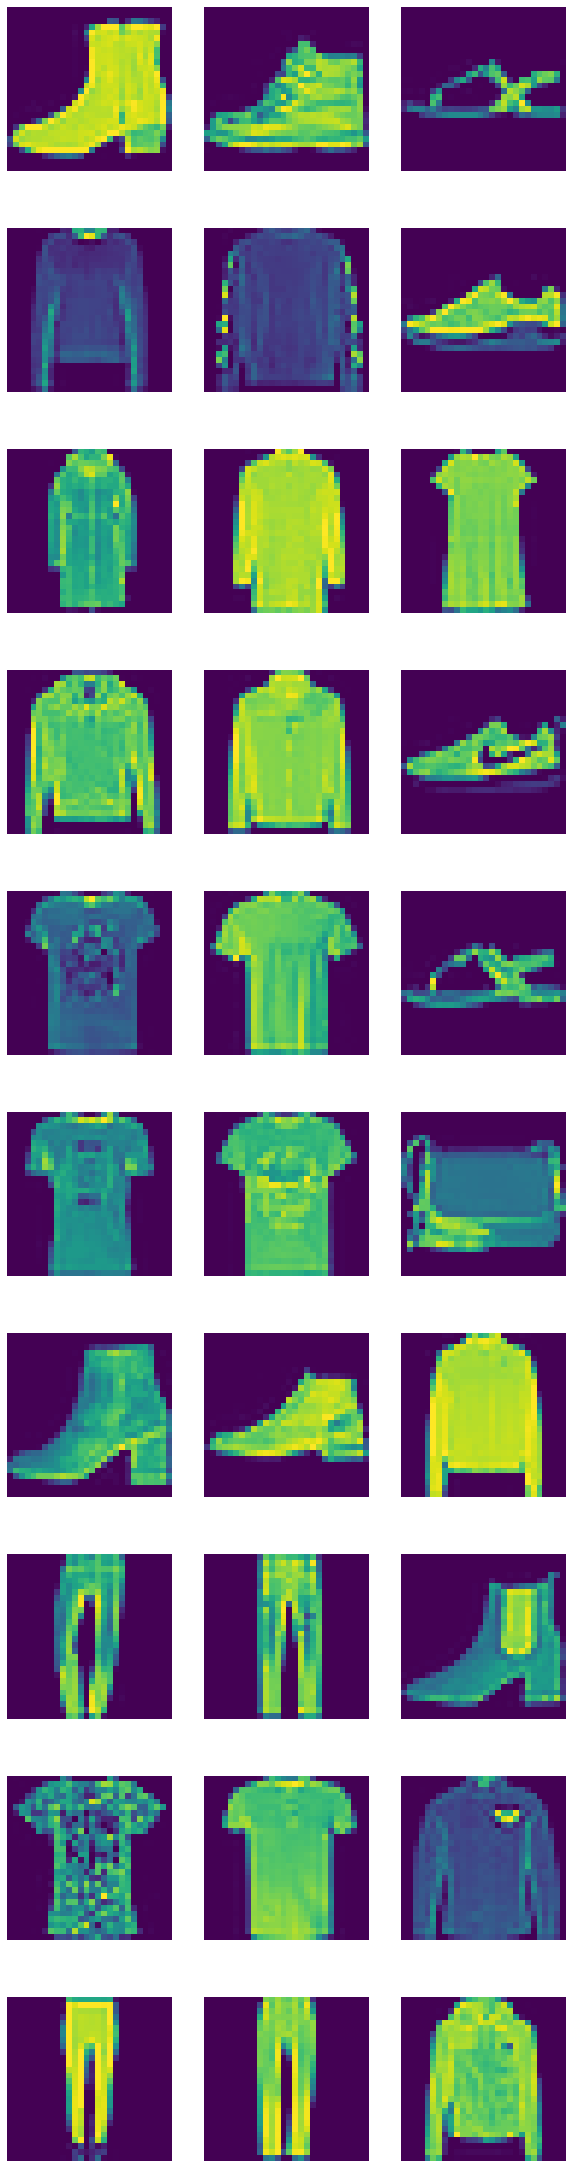

In [7]:

visualize(train_x)
#starting from the left in the images below - anchor, positive, negative. 

In [8]:
train_x, train_y = gen_triplets(x_train, y_train, num_train_per_class)
test_x, test_y = gen_triplets(x_test, y_test,5)

In [9]:
#generate embeddings for the achor, postive and negative images
def get_embeddings(input_shape, embedding_dim):
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(embedding_dim * 4,activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    return Model(_input, x)

# Compute the triplet loss based on Euclidean distance between the embeddings
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)

    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    loss = K.maximum(0.0, 1 + loss)

    return K.mean(loss)
        


In [10]:
def shuffle(inputs, labels):
  a, p, n = inputs
  l1, l2, l3 = labels
  randomizer = np.random.choice(a.shape[0], a.shape[0], replace=False)
  a = a[randomizer]
  p = p[randomizer]
  n = n[randomizer]

  l1 = l1[randomizer]
  l2 = l2[randomizer]
  l3 = l3[randomizer]
  return [a, p, n], [l1,l2,l3]

train_x, train_y = shuffle(train_x, train_y)

In [11]:

def siamese_network(input_shape, triplet_margin=.2, embedding_dim=100):

    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    embedding_model = get_embeddings(input_shape, embedding_dim)
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]

    siamese_triplet = Model(inputs=inputs,outputs=outputs)    
    siamese_triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus')))
    
    return embedding_model, siamese_triplet

In [12]:
embeddings, triplet = siamese_network((28,28,1), triplet_margin=.3, embedding_dim=150)
triplet.compile(loss=None, optimizer=Adam(0.0001))
history = triplet.fit(x=train_x, shuffle=True, batch_size=1000,
                              validation_split=.1, epochs=n_epochs)

Epoch 1/10
5/5 [==============================] - 1s 172ms/step - loss: 0.4535 - val_loss: 0.3368
Epoch 2/10
5/5 [==============================] - 1s 144ms/step - loss: 0.3300 - val_loss: 0.2847
Epoch 3/10
5/5 [==============================] - 1s 147ms/step - loss: 0.2806 - val_loss: 0.2582
Epoch 4/10
5/5 [==============================] - 1s 146ms/step - loss: 0.2468 - val_loss: 0.2310
Epoch 5/10
5/5 [==============================] - 1s 148ms/step - loss: 0.2258 - val_loss: 0.2101
Epoch 6/10
5/5 [==============================] - 1s 149ms/step - loss: 0.2084 - val_loss: 0.1971
Epoch 7/10
5/5 [==============================] - 1s 147ms/step - loss: 0.1883 - val_loss: 0.1882
Epoch 8/10
5/5 [==============================] - 1s 147ms/step - loss: 0.1785 - val_loss: 0.1814
Epoch 9/10
5/5 [==============================] - 1s 147ms/step - loss: 0.1652 - val_loss: 0.1766
Epoch 10/10
5/5 [==============================] - 1s 148ms/step - loss: 0.1581 - val_loss: 0.1746


In [13]:
train_embeds = embeddings.predict(np.vstack((train_x[0], train_x[1], train_x[2])))

In [14]:
target = np.hstack((train_y[0], train_y[1], train_y[2]))

In [15]:

def fit_nearest_neighbor(img_encoding, img_class, algorithm='ball_tree'):
  classifier = KNeighborsClassifier(n_neighbors=3, algorithm=algorithm)
  classifier.fit(img_encoding, img_class)
  return classifier

In [16]:
classifier = fit_nearest_neighbor(train_embeds, target)

In [17]:
e = embeddings.predict(x_test)
y_pred = classifier.predict(e)

In [18]:
#Return the mean accuracy on the given test data and labels.
print("number of training samples per class:",num_train_per_class)
print("mean accuracy:",classifier.score(e, y_test))


number of training samples per class: 500
mean accuracy: 0.8103


In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)

In [20]:
mat

array([[794,   2,  11,  33,   9,   2, 133,   0,  16,   0],
       [ 10, 960,   3,  19,   6,   0,   1,   0,   1,   0],
       [ 31,   2, 726,   8, 119,   1, 108,   0,   5,   0],
       [ 60,  16,  30, 812,  42,   1,  34,   0,   5,   0],
       [  3,   1, 179,  35, 672,   1, 105,   0,   4,   0],
       [  1,   0,   0,   0,   0, 818,   0, 107,   4,  70],
       [215,   1, 130,  28,  90,   0, 517,   0,  19,   0],
       [  0,   0,   0,   0,   0,  18,   0, 915,   0,  67],
       [  6,   2,  16,   7,   5,   6,   5,   4, 948,   1],
       [  0,   0,   0,   0,   0,   7,   0,  51,   1, 941]])